# Enhancing Pain Estimation through Synthetic Facial Image Generation and Deep Learning Models
# Student ID: 20533695
# User ID: psxah20

# Import necessary libraries

In [10]:
import pandas as pd
import numpy as np
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2, os, face_recognition, concurrent.futures

%matplotlib inline

# Datasets Paths

### Import Paths
##### The path for `The Delaware Pain Database: A Set of Painful Expressions and Corresponding Norming Data` is stored in **dpd_root_path**.

In [11]:
root_output = "D:/MS/Dissertation"

In [12]:
dpd_root_path = "Datasets/DPD Dataset/"

### Import Path for `open_cv` Frontal Face Model

In [13]:
haar_model_path = "Models/Face Detection Model/haarcascade_frontalface_default.xml"

### Import Paths for Undetected Faces for `face_recognition` Model

In [14]:
unidentified_faces_1 = "Logs/Unidentified Faces 1.csv"
unidentified_faces_2 = "Logs/Unidentified Faces 2.csv"

### Import Paths of Log for `open_cv` Model

In [15]:
opencv_log = "Logs/OpenCv logs.txt"

### Import Paths of Features cropped faces for `face_recogination` Model

In [16]:
features_cropped_faces = "Logs/Features Cropped Faces.csv"

### Import Paths of cropped faces

In [17]:
final_cropped_faces = "Output_results/Data_PreProcessing/Final_cropped_pictures/Cropped_Faces"

### Export Paths
##### The dataset from `The Delaware Pain Database: A Set of Painful Expressions and Corresponding Norming Data` is exported to **dpd_export_path_hog** and **dpd_export_path_cv**.

In [18]:
dpd_export_path_hog = "Output_results/Data_PreProcessing/Hog_Model/"
dpd_export_path_cv = "Output_results/Data_PreProcessing/OpenCv_Model/"

### Export Paths of plots visualized

In [19]:
plot_figures = "Output plots/"

### Export Paths of resized images

In [20]:
resized_image = "Output_results/Data_PreProcessing/DPD_Data_Resized/Resized_and_Normalized_Images_256x256/"

### Export Paths of pickle path

In [21]:
pickle_path = "Output_results/Data_PreProcessing/face_database.pkl"

#### Let"s analyze the folder structure of the `Delaware Pain Database`.

In [22]:
# Display directory list of delware pain dataset
images_types = os.listdir(path=dpd_root_path)
images_types

['Expression Images', 'FaceGen', 'Neutral Images', 'Neutral Only Images']

#### Let's explore the folder structure further for each of these categories: `Expressions`, `Neutral`, and `Neutral Only`.

In [23]:
# Selecting the Expression, Neutral and Neutral Only folders
expression_images = dpd_root_path + images_types[0] + "/"
netural_images = dpd_root_path + images_types[2] + "/"
neutral_only_images = dpd_root_path + images_types[3] + "/"

# Print the directories of these Expression, Neutral and Neutral Only folders.
print("Expression Images:/t", os.listdir(path=expression_images))
print("Neutral Images:\t\t", os.listdir(path=netural_images))
print("Neutral Only Images:\t", os.listdir(path=neutral_only_images))

Expression Images:/t ['Cropped and Standardized', 'Unedited']
Neutral Images:		 ['Cropped and Standardized', 'Unedited']
Neutral Only Images:	 ['Cropped and Standardized', 'Unedited']


##### `Note: We are not using FaceGen images for our project.`

##### We noticed that each folder contains identical `Cropped and Standardized` and `Unedited` subfolders. Since we won't be using the `Cropped and Standardized` for our project, as we will develop our own algorithm to crop and standardize the faces.

In [24]:
# Selecting the Unedited folder
expression_images_unedited = expression_images + os.listdir(path=expression_images)[1] + "/"
netural_images_unedited = netural_images + os.listdir(path=netural_images)[1] + "/"
neutral_only_images_unedited = neutral_only_images + os.listdir(path=neutral_only_images)[1] + "/"

# Print the directories of these Unedited folders.
print("Expression Images:   ", os.listdir(path=expression_images_unedited),"\n")
print("Neutral Images:      ", os.listdir(path=netural_images_unedited),"\n")
print("Neutral Only Images: ", os.listdir(path=neutral_only_images_unedited),"\n")

Expression Images:    ['Asian female participants', 'Asian male participants', 'Black female participants', 'Black male participants', 'Latinx female participants', 'Latinx male participants', 'Other female participants', 'Other male participants', 'White female participants', 'White male participants'] 

Neutral Images:       ['Asian female participants', 'Asian male participants', 'Black female participants', 'Black male participants', 'Latinx female participants', 'Latinx male participants', 'Other female participants', 'Other male participants', 'White female participants', 'White male participants'] 

Neutral Only Images:  ['DPD_1_AM21_N.JPG', 'DPD_1_AM22_N.JPG', 'DPD_1_AM23_N.JPG', 'DPD_1_BF33_N.JPG', 'DPD_1_BF34_N.JPG', 'DPD_1_BM30_N.JPG', 'DPD_1_LM15_N.JPG', 'DPD_1_OF7_N.JPG', 'DPD_1_WF37_N.JPG', 'DPD_1_WF38_N.JPG', 'DPD_1_WF39_N.JPG', 'DPD_1_WF40_N.JPG', 'DPD_1_WF41_N.JPG', 'DPD_1_WF42_N.JPG', 'DPD_1_WF43_N.JPG', 'DPD_1_WM44_N.JPG'] 



##### We can see that the `Expression Images` and `Neutral Images` folders further contain subfolders categorized by different races.

##### Let's dynamically create variables for these subfolders.

In [25]:
# Dynamic variable creation
print('Expression Images')
stored_folder_names = []
expr_male_length, expr_female_length, races = [], [], []

# Iterate over folders in Expression Images_unedited directory
for folder_name in os.listdir(expression_images_unedited):
    folder = folder_name[:-len('_participants')].lower().replace(' ','_')
    stored_folder_names.append(f"expression_{folder}")    
    globals()[f"expression_{folder}"] = glob(pathname=os.path.join(expression_images_unedited, folder_name, "*.jpg"))
    print(f"{folder_name} contains: {len(globals()[f'expression_{folder}'])} images. Stored in: expression_{folder}")
    
    # Determine gender and update respective lists
    if 'female' in folder:
        expr_female_length.append(len(globals()[f"expression_{folder}"]))
    else:
        expr_male_length.append(len(globals()[f"expression_{folder}"]))
        races.append(folder[:-len('_male')])

print('\nNeutral Images')
ntrl_male_length, ntrl_female_length = [], []

# Iterate over folders in Neutral Images_unedited directory
for folder_name in os.listdir(netural_images_unedited):
    folder = folder_name[:-len('_participants')].lower().replace(' ','_')
    stored_folder_names.append(f"neutral_{folder}")
    globals()[f"neutral_{folder}"] = glob(pathname=os.path.join(netural_images_unedited, folder_name, "*.jpg"))
    print(f"{folder_name} contains: {len(globals()[f'neutral_{folder}'])} images. Stored in: neutral_{folder}")
    
    # Determine gender and update respective lists
    if 'female' in folder:
        ntrl_female_length.append(len(globals()[f"neutral_{folder}"]))
    else:
        ntrl_male_length.append(len(globals()[f"neutral_{folder}"]))    

# Print summaries
print('\nSummary:')
print(f"Total Expression Images - Male: {sum(expr_male_length)}, Female: {sum(expr_female_length)}")
print(f"Total Neutral Images - Male: {sum(ntrl_male_length)}, Female: {sum(ntrl_female_length)}")
print(f"Races: {races}")

Expression Images
Asian female participants contains: 65 images. Stored in: expression_asian_female
Asian male participants contains: 38 images. Stored in: expression_asian_male
Black female participants contains: 84 images. Stored in: expression_black_female
Black male participants contains: 72 images. Stored in: expression_black_male
Latinx female participants contains: 49 images. Stored in: expression_latinx_female
Latinx male participants contains: 39 images. Stored in: expression_latinx_male
Other female participants contains: 23 images. Stored in: expression_other_female
Other male participants contains: 4 images. Stored in: expression_other_male
White female participants contains: 89 images. Stored in: expression_white_female
White male participants contains: 120 images. Stored in: expression_white_male

Neutral Images
Asian female participants contains: 27 images. Stored in: neutral_asian_female
Asian male participants contains: 20 images. Stored in: neutral_asian_male
Black fe

##### We can see there are 5 races with different numbers of image files in them. Let's create a pandas DataFrame to explore further.

# DataFrame Creation

### Creating Pandas dataframe for Images count
##### Let's create a Pandas DataFrame for Storing Numerical Information such as Number of Files in Neutral Folder, Expression Folder, Race Folder, etc.

In [26]:
# Prepare data for MultiIndex columns
genders = ['male', 'female']

# Initialize the dictionary for DataFrame creation
faces_data = {
    ('Expression Images', 'male'): expr_male_length,
    ('Expression Images', 'female'): expr_female_length,
    ('Neutral Images', 'male'): ntrl_male_length,
    ('Neutral Images', 'female'): ntrl_female_length
}

# Create the MultiIndex columns
columns = pd.MultiIndex.from_tuples(faces_data.keys())

# Create the DataFrame with provided data
faces_dataframe = pd.DataFrame(faces_data, index=races, columns=columns, dtype='int32')

# Calculate total values for each race (sum of each row)
totals_race = faces_dataframe.sum(axis=1)

# Calculate total values for each gender/category (sum of each column)
totals_gender = faces_dataframe.sum(axis=0)

# Add totals for each race as a new column
faces_dataframe['Total'] = totals_race.values

# Display the updated DataFrame
faces_dataframe.loc['total'] = totals_gender

# Set a new value for the 'total' index and 'Expression Images' 'male' multi-column
faces_dataframe.loc['total', ('Expression Images', 'male')] = totals_gender[('Expression Images', 'male')]
faces_dataframe.loc['total', 'Total'] = faces_dataframe['Total'].sum()

# Display the first few rows of the face dataframe to verify the stored data
faces_dataframe

Expression Images        Neutral Images         Total
                    male female           male female       
asian               38.0   65.0           20.0   27.0  150.0
black               72.0   84.0           28.0   31.0  215.0
latinx              39.0   49.0           14.0   18.0  120.0
other                4.0   23.0            2.0    6.0   35.0
white              120.0   89.0           38.0   35.0  282.0
total              273.0  310.0          102.0  117.0  802.0

### Creating a Pandas DataFrame for Files Information
##### Let's create a Pandas DataFrame to store information about images, including their file path, folder type, race, gender, dimensions, and Image Matrix.

In [27]:
def process_file(file_name, folder_name):
    # Replace backslashes with forward slashes in the file path
    replaced = file_name.replace('\\', '/')
    # Split the file path into parts
    selected = replaced.split('/')

    # Extract folder, race, gender, and file name based on the file path structure
    folder = selected[-4]  # Adjust the indexing based on your folder structure
    race = selected[-2].split()[0].lower()
    gender = selected[-2].split()[1].lower()
    file_name_only = selected[-1].split('.')[0]

    # Read the image file
    image = cv2.imread(replaced)
    height, width = image.shape[:2]

    # Return a dictionary with the extracted information
    return {
        'File Paths': replaced,
        'Folder Types': folder,
        'File Names': file_name_only,
        'Races': race,
        'Genders': gender,
        'Original Image Width': width,
        'Original Image Height': height,
    }

# Initialize a dictionary to store the results
faces_db = {
    'File Paths': [],
    'Folder Types': [],
    'File Names': [],
    'Races': [],
    'Genders': [],
    'Original Image Width': [],
    'Original Image Height': [],
}

# Initialize an array to store column names
column = ['File Paths', 'Folder Types', 'File Names', 'Races', 'Genders', 'Original Image Width', 'Original Image Height']

# Flatten the list of files to be processed
files_to_process = [(file_name, folder_name) for folder_name in stored_folder_names for file_name in globals()[folder_name]]

# Process files in parallel using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use map to apply process_file function to each file in files_to_process
    for result in executor.map(lambda x: process_file(x[0], x[1]), files_to_process):
        faces_db['File Paths'].append(result['File Paths'])
        faces_db['Folder Types'].append(result['Folder Types'])
        faces_db['File Names'].append(result['File Names'])
        faces_db['Races'].append(result['Races'])
        faces_db['Genders'].append(result['Genders'])
        faces_db['Original Image Width'].append(result['Original Image Width'])
        faces_db['Original Image Height'].append(result['Original Image Height'])

# Convert faces_db to a pandas DataFrame
face_database = pd.DataFrame(data=faces_db, columns=column)

# Display the first few rows of the face database to verify the stored data
face_database.head()

File Paths       Folder Types  \
0  Datasets/DPD Dataset/Expression Images/Unedite...  Expression Images   
1  Datasets/DPD Dataset/Expression Images/Unedite...  Expression Images   
2  Datasets/DPD Dataset/Expression Images/Unedite...  Expression Images   
3  Datasets/DPD Dataset/Expression Images/Unedite...  Expression Images   
4  Datasets/DPD Dataset/Expression Images/Unedite...  Expression Images   

       File Names  Races Genders  Original Image Width  Original Image Height  
0  DPD_1_AF10_p2c  asian  female                  5152                   3864  
1  DPD_1_AF10_p4c  asian  female                  5152                   3864  
2  DPD_1_AF10_p6c  asian  female                  5152                   3864  
3  DPD_1_AF11_p6c  asian  female                  5152                   3864  
4  DPD_1_AF12_p3c  asian  female                  5152                   3864

### Creating Pandas DataFrame to Store Pain Score Information
##### Let's create a Pandas DataFrame to store information about each person's neutral face and the number of that person's images with corresponding pain scores.

In [28]:
# Initialize dictionaries to store participants and neutral participants
participants, participants_neutral = {}, {}

# Iterate over each file name in the 'face_database'
for file_name, race, gender in zip(face_database['File Names'], face_database['Races'], face_database['Genders']):
    # Split the file name by underscores
    splitted_name = file_name.split('_')

    # Check if the file name indicates a participant with pain score
    if 'p' in splitted_name[-1]:
        # Extract participant's name and pain score
        face_name, pain_score = splitted_name[2], splitted_name[3][1]

        # Add participant to 'participants' dictionary if not already present
        if face_name not in participants.keys():
            participants[face_name] = [(pain_score, race, gender)]
        else:
            participants[face_name].append((pain_score, race, gender))
    else:
        # Extract participant's name (neutral case)
        face_name = splitted_name[-1]

        # Add participant to 'participants_neutral' dictionary if not already present
        if face_name not in participants_neutral.keys():
            participants_neutral[face_name] = [0, race, gender]
        else:
            participants_neutral[face_name].append((0, race, gender))

# Print the number of participants and neutral participants
print(len(participants))  # Number of participants with pain scores
print(len(participants_neutral))  # Number of participants with neutral faces

222
219


##### We are organizing participants' data, handling pain scores, race, and gender. We create DataFrames for participants with and without pain, ensuring consistent data representation by setting 25.0 as a placeholder for missing values.

In [29]:
# Extract values from participants dictionary
input_list = list(participants.values())

# Specify the length of each ' list as 9, corresponding to indices 0 to 6 and slots for race and gender
target_length = 9  

# Initialize the output list with '25.0's as placeholders for each participant.
# Setting 25.0 as our null value to replace NaNs in the dataset
output_list = [['25.0'] * target_length for _ in range(len(participants))]  

# Fill in the numbers from input_list at the correct positions
for inx, valu in enumerate(input_list):  
    for num, race, gender in valu:
        index = int(num)  # Convert num to an integer index.
        output_list[inx][index] = num  # Update the output_list with actual values at specified indices.
        output_list[inx][7] = race  # Add race information.
        output_list[inx][8] = gender  # Add gender information.
        
# Create a DataFrame for participants with pain, converting keys to lowercase
faces_with_pain = pd.DataFrame(data=output_list, index=[l.lower() for l in list(participants.keys())])

# Create a DataFrame for participants without pain, converting keys to lowercase
faces_without_pain = pd.DataFrame(data=participants_neutral.values(), index=[l.lower() for l in list(participants_neutral.keys())])

##### We are combining `faces_without_pain` and a modified `faces_with_pain` into the `faces_combined` DataFrame. We set `25.0` as our null value to replace NaNs in the dataset. Finally, we ensure `faces_combined` is ready for numerical operations.

In [30]:
# Combining faces_without_pain and modified faces_with_pain into faces_combined DataFrame
faces_combined = pd.concat(objs=[faces_without_pain[0], faces_with_pain.drop([0], axis=1)], axis=1)

# Setting 25.0 as our null value to replace NaNs in the dataset
faces_combined.loc[faces_combined[0].isnull(), 0] = 25.0

# Setting columns for face_combined
faces_combined.columns = ['Neutral','Prompt1','Prompt2','Prompt3','Prompt4','Prompt5','Prompt6','Races','Gender']

# Display the first few rows of the face database to verify the stored data
faces_combined.head()

Neutral Prompt1 Prompt2 Prompt3 Prompt4 Prompt5 Prompt6  Races  Gender
af1       0.0    25.0       2    25.0       4       5       6  asian  female
af10      0.0    25.0       2    25.0       4    25.0       6  asian  female
af11      0.0    25.0    25.0    25.0    25.0    25.0       6  asian  female
af12      0.0    25.0    25.0       3       4    25.0       6  asian  female
af13      0.0    25.0       2       3    25.0    25.0       6  asian  female

In [31]:
# Convert the entire DataFrame to integers
faces_combined_melt = faces_combined[['Neutral','Prompt1','Prompt2','Prompt3','Prompt4','Prompt5','Prompt6']].melt()
faces_combined_melt['value'] = faces_combined_melt['value'].astype('float64')
faces_combined_melt = faces_combined_melt[faces_combined_melt['value']!=25.0]

# Display the first few rows of the face database to verify the stored data
faces_combined_melt.head()

variable  value
0  Neutral    0.0
1  Neutral    0.0
2  Neutral    0.0
3  Neutral    0.0
4  Neutral    0.0

# Missing Values
##### Let's check for missing values.

In [32]:
# Display any null values if present in dataframe after replacing actual null values with 25.0.
faces_combined.isnull().sum()

Neutral    0
Prompt1    0
Prompt2    0
Prompt3    0
Prompt4    0
Prompt5    0
Prompt6    0
Races      0
Gender     0
dtype: int64

#### There are no missing values we can proceed with EDA and Data Visualization

In [33]:
pain_score_excel = pd.read_excel(io="D:/MS/Dissertation/Datasets/DPD Data ZIP/DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx",
                                sheet_name='DPD_NormingData')
pain_score_excel

d:\Software\Anaconda\envs\torch2\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Target                                  Consent    Race  \
0             DPD_1_OF8_p2c  publication materials/website materials  Arabic   
1             DPD_1_OF8_p3c  publication materials/website materials  Arabic   
2             DPD_1_OF8_p4c  publication materials/website materials  Arabic   
3    DPD_1_AF6_nosering_p2c                                     full   Asian   
4    DPD_1_AF6_nosering_p4c                                     full   Asian   
..                      ...                                      ...     ...   
725           DPD_1_WM22_p1                                     full   White   
726           DPD_1_WM23_p1                                     full   White   
727           DPD_1_WM42_p1                                     full   White   
728           DPD_1_WM24_p1                                     full   White   
729           DPD_1_WM25_p1                                     full   White   

     Gender  Masculine_Neutral  Feminine_Neutral  BabyFaced_Neutral  \
0    Female           3.268293          3.756098           2.463415   
1    Female           3.268293          3.756098           2.463415   
2    Female           3.268293          3.756098           2.463415   
3    Female           2.224138          5.413793           4.051724   
4    Female           2.224138          5.413793           4.051724   
..      ...                ...               ...                ...   
725    Male           4.750000          1.954546           2.863636   
726    Male           5.044444          2.155556           2.955556   
727    Male           4.186046          2.418605           4.348837   
728    Male           5.347826          1.630435           2.282609   
729    Male           5.534884          1.627907           2.000000   

     Trustworthy_Neutral  Dominant_Neutral  Attractive_Neutral  ...  AU12_OF  \
0               3.243902          2.731707            2.560976  ...        1   
1               3.243902          2.731707            2.560976  ...        1   
2               3.243902          2.731707            2.560976  ...        1   
3               4.603448          3.206897            3.862069  ...        0   
4               4.603448          3.206897            3.862069  ...        0   
..                   ...               ...                 ...  ...      ...   
725             3.681818          3.045454            2.590909  ...        1   
726             3.555556          3.844444            3.622222  ...        1   
727             3.813954          2.906977            3.116279  ...        1   
728             3.847826          3.413044            3.282609  ...        1   
729             4.023256          4.186046            3.604651  ...        0   

     AU14_OF  AU15_OF  AU17_OF  AU20_OF  AU23_OF  AU25_OF  AU26_OF  AU28_OF  \
0          1        1        0        0        1        1        0        0   
1          1        1        1        0        1        0        0        0   
2          1        0        1        0        0        0        0        0   
3          0        0        1        0        0        0        0        0   
4          0        0        1        0        0        1        0        0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
725        1        0        0        0        1        1        0        1   
726        1        0        0        0        0        0        0        1   
727        1        0        1        0        0        0        0        0   
728        1        0        1        0        0        1        0        0   
729        1        1        1        0        1        0        0        1   

     AU45_OF  
0          1  
1          1  
2          1  
3          0  
4          0  
..       ...  
725        1  
726        0  
727        1  
728        1  
729        0  

[730 rows x 88 columns]

# Exploratory Data Analysis (EDA) and Data Visualization

##### We are visualizing the distribution and proportion of three categorical variables (`Folder Types`, `Races`, and `Genders`) from the `face_database dataset` using a combination of count plots and pie charts. The figure consists of six subplots arranged in a 2x3 grid:

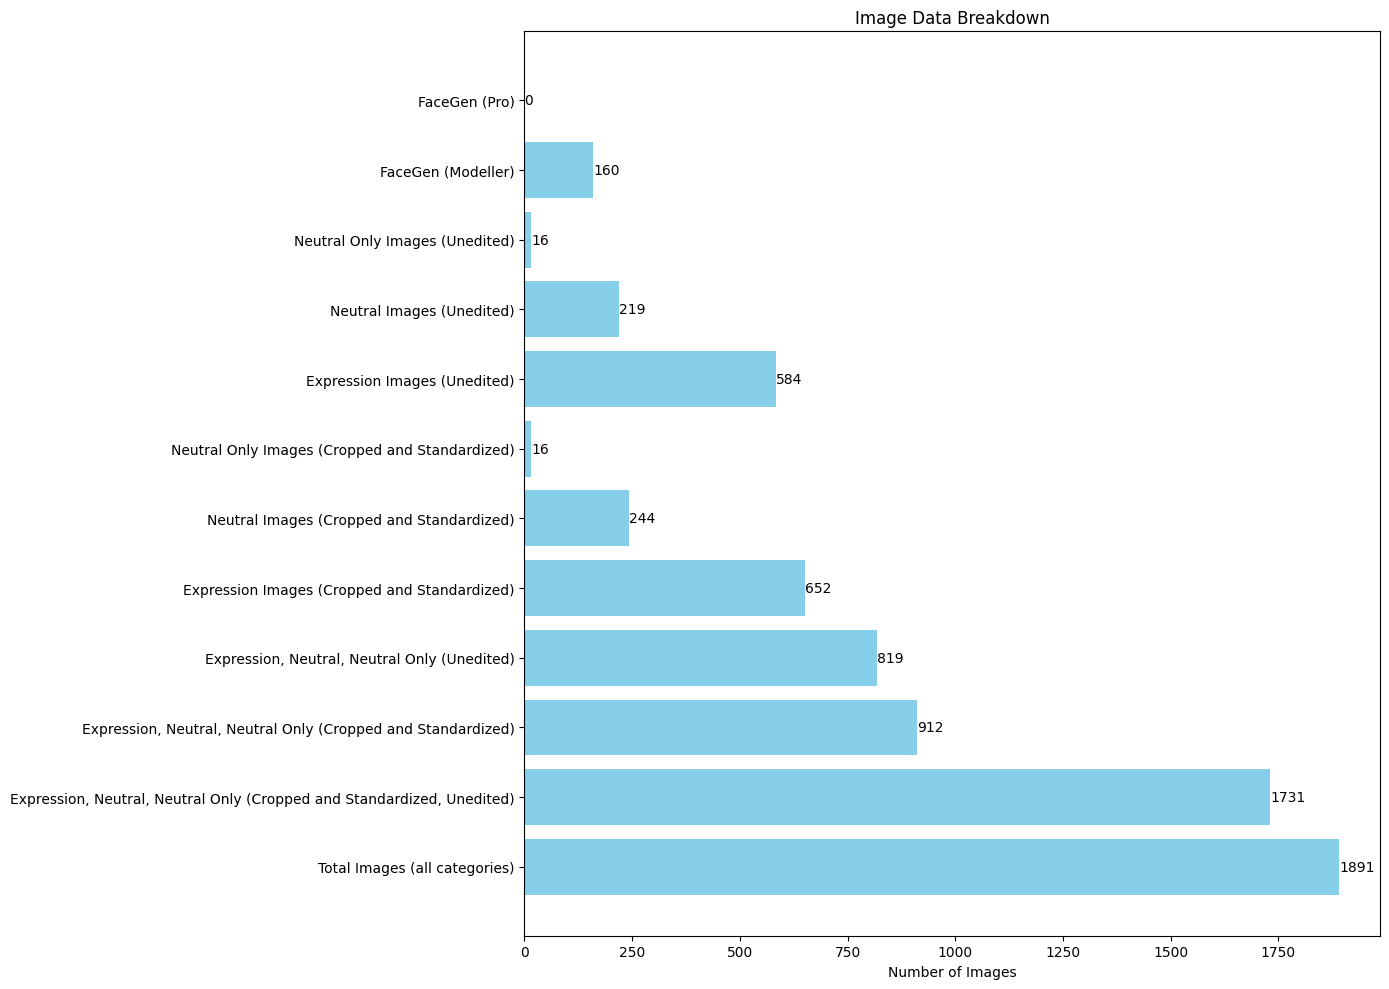

In [34]:
# Data to plot a graph to show distribution of files.
categories = [
    'Total Images (all categories)', 'Expression, Neutral, Neutral Only (Cropped and Standardized, Unedited)',
    'Expression, Neutral, Neutral Only (Cropped and Standardized)', 'Expression, Neutral, Neutral Only (Unedited)',
    'Expression Images (Cropped and Standardized)', 'Neutral Images (Cropped and Standardized)',
    'Neutral Only Images (Cropped and Standardized)', 'Expression Images (Unedited)', 
    'Neutral Images (Unedited)', 'Neutral Only Images (Unedited)', 'FaceGen (Modeller)', 'FaceGen (Pro)'
]

counts = [1891,1731,912,819,652,244,16,584,219,16,160,0]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.barh(categories, counts, color='skyblue')
plt.xlabel('Number of Images')
plt.title('Image Data Breakdown')

# Add counts on the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{count}", va='center')

plt.tight_layout()
plt.savefig(plot_figures+'Total_counts.png')
plt.show()

#### We are creating a series of subplots to visualize the distribution and proportion of Folder Types, Races, and Genders in the face_database dataset using count plots and pie charts. 

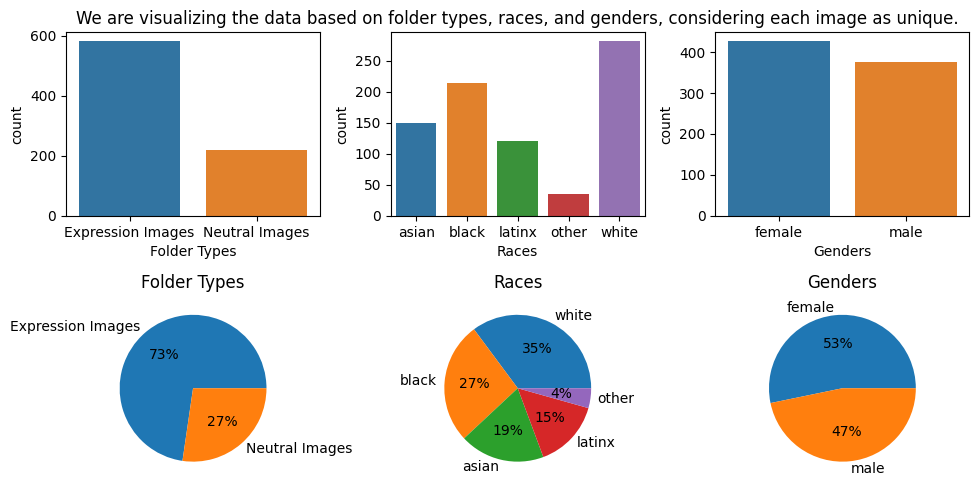

In [35]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Subplot 1: Distribution of Folder Types
plt.subplot(2, 3, 1)
sns.countplot(data=face_database, x='Folder Types', hue='Folder Types')

# Subplot 2: Distribution of Races
plt.subplot(2, 3, 2)
plt.title('We are visualizing the data based on folder types, races, and genders, considering each image as unique.')
sns.countplot(data=face_database, x='Races', hue='Races')

# Subplot 3: Distribution of Genders
plt.subplot(2, 3, 3)
sns.countplot(data=face_database, x='Genders', hue='Genders')

# Subplot 4: Proportion of Folder Types
plt.subplot(2, 3, 4)
face_database['Folder Types'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Folder Types')
plt.xlabel('')
plt.ylabel('')

# Subplot 5: Proportion of Races
plt.subplot(2, 3, 5)
face_database['Races'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Races')
plt.xlabel('')
plt.ylabel('')

# Subplot 6: Proportion of Genders
plt.subplot(2, 3, 6)
face_database['Genders'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Genders')
plt.xlabel('')
plt.ylabel('')

# Show the plots
plt.tight_layout()
plt.savefig(plot_figures+'Images_distribution.png')
plt.show()

Let's Visualize pain score

C:\Users\Asus\AppData\Local\Temp\ipykernel_12400\1229343351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pain_score_excel_1['OpenFace_PainIndex'] = pain_score_excel_1['OpenFace_PainIndex'].astype(int)
C:\Users\Asus\AppData\Local\Temp\ipykernel_12400\1229343351.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pain_score_excel_1, x='OpenFace_PainIndex', palette="viridis")


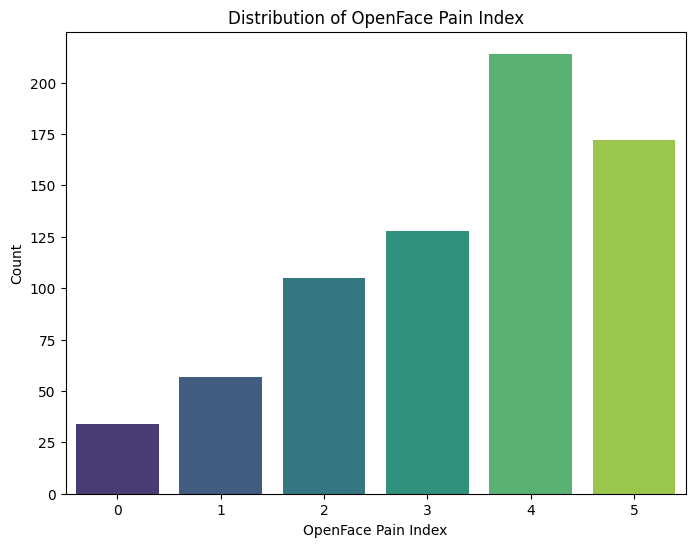

In [36]:
pain_score_excel_1 = pain_score_excel[pain_score_excel['OpenFace_PainIndex'].apply(lambda x: str(x).isdigit())]

pain_score_excel_1['OpenFace_PainIndex'] = pain_score_excel_1['OpenFace_PainIndex'].astype(int)

# Now plot the count plot without the '.' values
plt.figure(figsize=(8, 6))
sns.countplot(data=pain_score_excel_1, x='OpenFace_PainIndex', palette="viridis")
plt.xlabel('OpenFace Pain Index')
plt.ylabel('Count')
plt.title('Distribution of OpenFace Pain Index')
plt.show()

##### We are visualizing the relationship between `Original Image Width` and `Original Image Height` for different genders and races in the `face_database` dataset using joint plots.

<Figure size 1000x400 with 0 Axes>

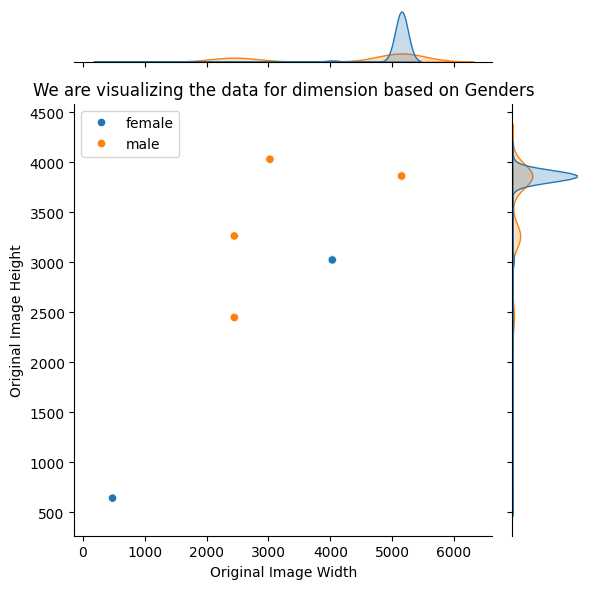

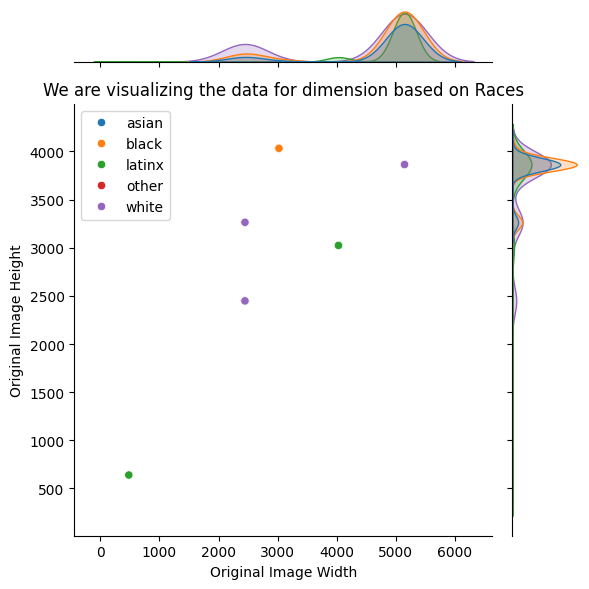

In [37]:
# Set the figure size
plt.figure(figsize=(10, 4))

# Create a jointplot for Genders
sns.jointplot(data=face_database, x='Original Image Width', y='Original Image Height', hue='Genders')
plt.title('We are visualizing the data for dimension based on Genders')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# Adjust the layout to avoid overlap
plt.tight_layout()

# Save figure
plt.savefig(plot_figures+'race_joinplot.png')

# Create a jointplot for Races
sns.jointplot(data=face_database, x='Original Image Width', y='Original Image Height', hue='Races')
plt.title('We are visualizing the data for dimension based on Races')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# Adjust the layout to avoid overlap
plt.tight_layout()

# Save figure
plt.savefig(plot_figures+'gender_joinplot.png')

# Show the plots
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_12400\2031107091.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=faces_combined_melt, x='variable', palette='Set2')


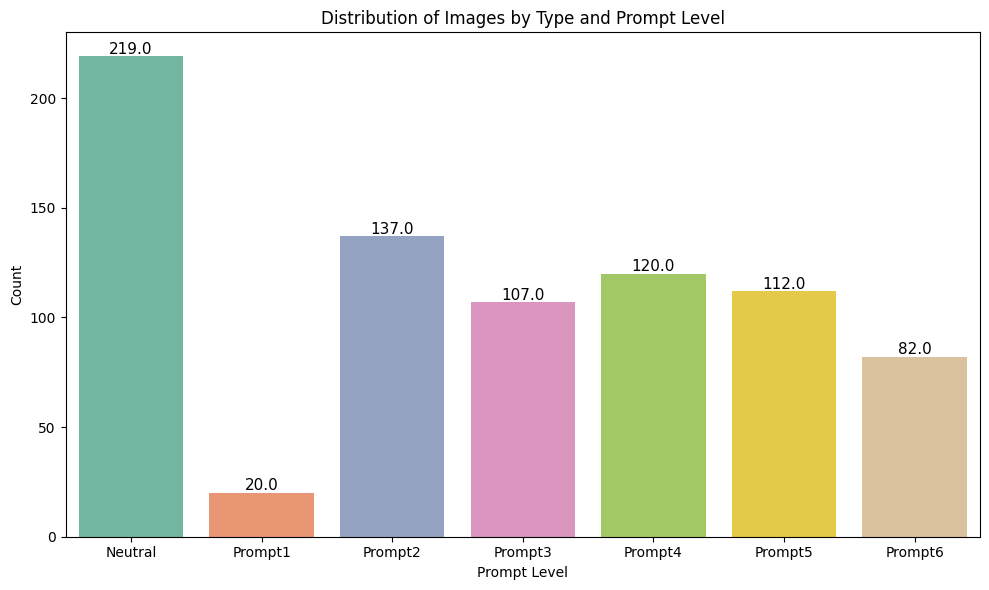

In [38]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Create countplot
sns.countplot(data=faces_combined_melt, x='variable', palette='Set2')

# Annotate each bar with its count
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')

# Add title and labels
plt.title('Distribution of Images by Type and Prompt Level')
plt.xlabel('Prompt Level')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig(plot_figures+'count_plots.png', dpi=300)
# 150x150

C:\Users\Asus\AppData\Local\Temp\ipykernel_12400\3353126633.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Missing Data' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  faces_combined_adjusted.loc[faces_combined_adjusted['Neutral'] == 25.0, 'Neutral'] = 'Missing Data'


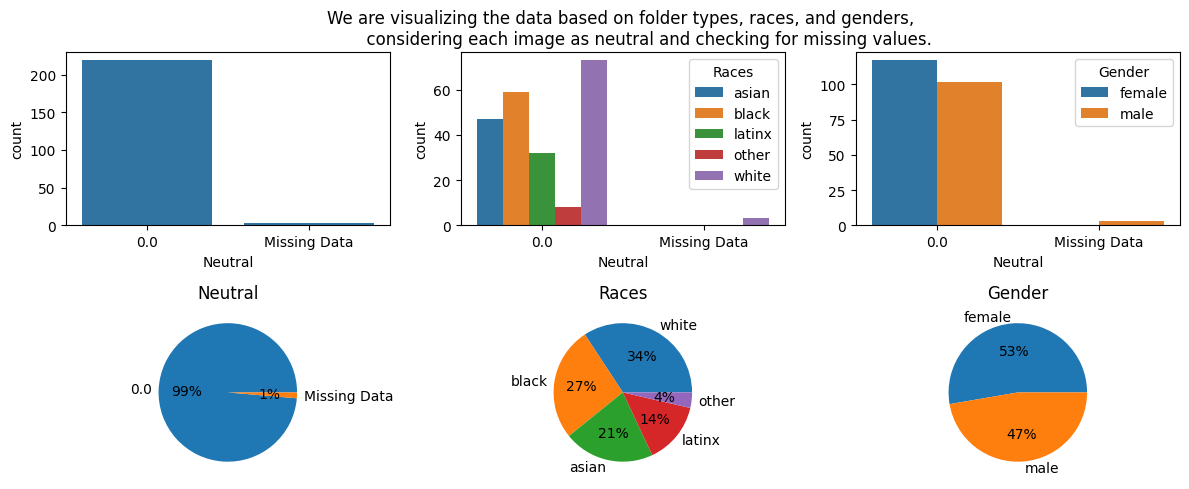

In [39]:
# Adjusting 25.0 as Missing value.
faces_combined_adjusted = faces_combined.copy()

# Replace values equal to 25.0 with 'Missing Data'
faces_combined_adjusted.loc[faces_combined_adjusted['Neutral'] == 25.0, 'Neutral'] = 'Missing Data'

# Set the figure size
plt.figure(figsize=(12, 5))

# Subplot 1: Distribution of Neutral
plt.subplot(2, 3, 1)
sns.countplot(data=faces_combined_adjusted, x='Neutral')

# Subplot 2: Distribution of Neutral vs Races
plt.subplot(2, 3, 2)
plt.title('''We are visualizing the data based on folder types, races, and genders, 
          considering each image as neutral and checking for missing values.''')
sns.countplot(data=faces_combined_adjusted, x='Neutral', hue='Races')

# Subplot 3: Distribution of Neutral vs Gender
plt.subplot(2, 3, 3)
sns.countplot(data=faces_combined_adjusted, x='Neutral', hue='Gender')

# Subplot 4: Proportion of Neutral
plt.subplot(2, 3, 4)
faces_combined_adjusted['Neutral'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Neutral')
plt.xlabel('')
plt.ylabel('')

# Subplot 5: Proportion of Neutral vs Races
plt.subplot(2, 3, 5)
faces_combined_adjusted['Races'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Races')
plt.xlabel('')
plt.ylabel('')

# Subplot 6: Proportion of Neutral vs Gender
plt.subplot(2, 3, 6)
faces_combined_adjusted['Gender'].value_counts().plot(kind='pie', autopct='%0.0f%%')
plt.title('Gender')
plt.xlabel('')
plt.ylabel('')

# Show the plots
plt.tight_layout()

# Save figure
plt.savefig(plot_figures+'neutral_distributions.png')
plt.show()

# Image Preprocessing: Face Cropping
## Face Detection Models

### Face Detection using `face_recognition` Library

##### We are enhancing images from `face_database['File Paths']` by detecting faces and drawing bounding boxes around them. This process involves:
- Iterating through each file path in `face_database['File Paths']`.
- Utilizing the `face_recognition` library to detect faces in each image.
- Drawing green bounding boxes around the detected faces.
- Saving the modified images to the specified directory `dpd_export_path_hog`.

This approach improves image clarity and prepares them for further analysis or applications, such as facial recognition systems.

In [29]:
def face_recognition_model(file, image_file, export_path, upsample=1, model_type='hog', x_add_diff=25, y_add=100, y_diff=200):
    # Create a copy of the input image for further processing
    image_file = image_file.copy()
    image_file_copy = image_file.copy()

    # Split the file path to determine the export folder structure
    file_split = file.split('/')

    # Detect face locations in the image using the face_recognition library
    face_locations = face_recognition.face_locations(img=image_file, number_of_times_to_upsample=upsample, model=model_type)

    # Check if any faces were detected
    if not face_locations:
        print(f"No faces detected in {file_split[-1]}")
    else:
        # Iterate over the detected face locations
        for top, right, bottom, left in face_locations:
            x, y, width, height = left, top, right - left, bottom - top
            
            # Define points for drawing rectangles and cropping based on image size
            if image_file.shape[0] > 1000 and image_file.shape[1] > 1000:
                pt1 = (x - x_add_diff, y - y_diff)
                pt2 = (x + width + x_add_diff, y + height + y_add)
                size_1_y_start = y - y_diff
                size_1_y_end = y + height + y_add
                size_1_x_start = x - x_add_diff
                size_1_x_end = x + width + x_add_diff
            else:
                pt1 = (x, y)
                pt2 = (x + width, y + height)
                size_1_y_start = y
                size_1_y_end = y + height
                size_1_x_start = x
                size_1_x_end = x + width

            # Draw a rectangle around the detected face
            cv2.rectangle(img=image_file, pt1=pt1, pt2=pt2, color=(0, 255, 0), thickness=2)
            # Crop the face from the image
            face_cropped = image_file_copy[size_1_y_start:size_1_y_end, size_1_x_start:size_1_x_end]

        # Ensure the directories for saving images exist
        identified_full_faces_dir = os.path.join(export_path, 'Identified Full Faces', file_split[-4], file_split[-2])
        cropped_faces_dir = os.path.join(export_path, 'Cropped Faces', file_split[-4], file_split[-2])
        os.makedirs(identified_full_faces_dir, exist_ok=True)
        os.makedirs(cropped_faces_dir, exist_ok=True)
        
        # Save the image with rectangles drawn around faces
        cv2.imwrite(filename=os.path.join(identified_full_faces_dir, file_split[-1]), img=image_file)
        # Save the cropped face image
        cv2.imwrite(filename=os.path.join(cropped_faces_dir, file_split[-1]), img=face_cropped)

        # Indicate that the processing for the current file is complete
        print(f"File {file_split[-1]} - Processing done.")

##### The code below runs the `face_recognition_model` function, cropping and exporting the files to the given path.

In [30]:
# # Loop through the file paths and corresponding images in the face_database
# for index, (file, image_file) in enumerate(zip(face_database['File Paths'], face_database['Original Image Data'])):
#     # Call the face_recognition_model function for each file and image
#     face_recognition_model(file, image_file, dpd_export_path_hog, upsample=1, model_type='hog')

### Detecting Faces using Haar Cascade Classifier (OpenCV)

##### We use a Haar Cascade Classifier (`haarcascade_frontalface_default.xml`) to detect faces in images from `face_database['File Paths']`. The process includes:
- Loading the Haar Cascade classifier model.
- Iterating through each file path in `face_database['File Paths']`.
- Converting the RGB image to grayscale.
- Detecting faces using the Haar model with specified parameters (`scaleFactor=1.5`, `minNeighbors=7`).
- Drawing green bounding boxes around detected faces on the original image.
- Saving the modified images to a specified directory (`dpd_export_path_cv`).

In [31]:
def opencv_model(file, image_file, haar_model=haar_model_path, dpd_export_path=dpd_export_path_cv):
    # Create copies of the input image for processing
    image_file = image_file.copy()
    image_file_copy = image_file.copy()
    
    # Convert the RGB image to grayscale for face detection
    image_gray = cv2.cvtColor(src=image_file, code=cv2.COLOR_BGR2GRAY)
    
    # Detect faces using the Haar Cascade Classifier
    detect_faces = haar_model.detectMultiScale(image=image_gray, scaleFactor=1.5, minNeighbors=7)
    
    # Check the number of faces detected and handle accordingly
    if len(detect_faces) == 0:
        print(f"{file} - No face detected.")
        return 'no_face'
    elif len(detect_faces) > 1:
        print(f"{file} - More than one face detected.")
        return 'more_faces'
    else:    
        # Iterate over the detected faces and process each one
        for x, y, width, height in detect_faces:
            # Draw a rectangle around the detected face
            cv2.rectangle(img=image_file, pt1=(x, y), pt2=(x + width, y + height), color=(0, 255, 0), thickness=2)
            # Crop the face from the image
            face_cropped = image_file_copy[y:y+height, x:x+width]
        
        # Split the file path to determine the export folder structure
        file_split = file.split('/')
        
        # Ensure the directories for saving images exist
        identified_full_faces_dir = os.path.join(dpd_export_path, 'Identified Full Faces', file_split[-4], file_split[-2])
        cropped_faces_dir = os.path.join(dpd_export_path, 'Cropped Faces', file_split[-4], file_split[-2])
        os.makedirs(identified_full_faces_dir, exist_ok=True)
        os.makedirs(cropped_faces_dir, exist_ok=True)
        
        # Save the image with rectangles drawn around faces
        cv2.imwrite(filename=os.path.join(identified_full_faces_dir, file_split[-1]), img=image_file)
        # Save the cropped face image
        cv2.imwrite(filename=os.path.join(cropped_faces_dir, file_split[-1]), img=face_cropped)
        
        # Indicate that the processing for the current file is complete
        print(f"{file} - Processing done.")
        return 'processed'

##### The code below runs the `opencv_model` function, cropping and exporting the files to the given path.

In [32]:
# # Initialize an empty array to store file names of images when faces are not detected
# no_faces = []

# # Initialize an empty array to store file names of images when more than 2 faces are detected
# more_faces = []

# # Loop through file paths in face_database
# for file, image_file in zip(face_database['File Paths'], face_database['Original Image Data']):
#     result = opencv_model(file, image_file, cv2.CascadeClassifier(haar_model_path), dpd_export_path_cv)
#     if result == 'no_face':
#         no_faces.append(file)
#     elif result == 'more_faces':
#         more_faces.append(file)

# Evaluation

### Evaluation of  `face_recoginition` model.
##### Each image was checked manually, and some images were found with multiple faces detected and some faces were not cropped correctly. The image names that were not properly processed were noted and stored in a text file `Unidentified Faces 1.csv` and `Features Cropped Faces.csv`.

### Creating a method to show images

In [33]:
def show_image(image, axes, index):
    # Display the image using matplotlib on the specified axis
    return axes.imshow(image)

In [34]:
# Read the CSV file containing unidentified faces into a DataFrame
# The CSV is expected to have columns for 'Identified Full Faces' and 'Cropped Faces'
unidentified_faces_df = pd.read_csv(filepath_or_buffer=unidentified_faces_1, names=['Identified Full Faces', 'Cropped Faces'])

# Read the CSV file containing features of cropped faces into a DataFrame
# The CSV is expected to have columns for 'Identified Full Faces' and 'Cropped Faces'
features_cropped_df = pd.read_csv(filepath_or_buffer=features_cropped_faces, names=['Identified Full Faces', 'Cropped Faces'])

# Print the number of rows in the DataFrame containing unidentified faces
print('Unidentified Faces:\t', len(unidentified_faces_df))

# Print the number of rows in the DataFrame containing features of cropped faces
print('Features Cropped:\t', len(features_cropped_df))

Unidentified Faces:	 13
Features Cropped:	 2


#### There are 13 faces which got detected with multiple faces and 7 faces are not cropped correctly. Let's re-run the hog model by `number_of_times_to_upsample` to 2.

In [35]:
# # Loop through file paths in unidentified_faces_df DataFrame
# for index, file in enumerate(unidentified_faces_df['Identified Full Faces']):
#     # Extract the file name without the extension from the full file path
#     file_split = file.split('/')[-1].split('.')[0]
    
#     # Find the corresponding file path in the face_database DataFrame
#     file_path = face_database[face_database['File Names'] == file_split]['File Paths'].values[0]
    
#     # Run the face_recognition_model function after upsampling the model by 2.
#     face_recognition_model(file=file_path, 
#                            image_file=cv2.imread(filename=file_path), 
#                            export_path=dpd_export_path_hog, 
#                            upsample=2, 
#                            model_type='hog')

In [36]:
# Read the CSV file into a DataFrame
# The CSV is expected to have columns for 'Identified Full Faces' and 'Cropped Faces'
unidentified_upsampled_face_df = pd.read_csv(filepath_or_buffer=unidentified_faces_2, names=['Identified Full Faces', 'Cropped Faces'])

# Print the number of rows in the DataFrame, indicating the count of unidentified faces
print('Unidentified Faces:\t', len(unidentified_upsampled_face_df))

Unidentified Faces:	 7


##### The following images are displayed based on specified indices and conditions:
- Full Images: These plots show the full images processed with a specified suffix.
- Cropped Images: These images display cropped versions corresponding to the full images.
##### Each plot set is tailored according to the parameters `figsize`.

In [37]:
def visualize_images(root_output, dataframe, indices, title_suffix, figsize=(30, 10), combined_fig_path='combined_figure.png'):
    # Create a single figure for both full and cropped images
    fig, axes = plt.subplots(2, len(indices), figsize=figsize)
    fig.suptitle(f"Full and Cropped Images {title_suffix}", fontsize=24, y=0.95)
    
    # Iterate through the specified indices
    for index, i in enumerate(indices):
        full_img = root_output+dataframe['Identified Full Faces'][i]
        crop_img = root_output+dataframe['Cropped Faces'][i]
        
        if os.path.exists(full_img) and os.path.exists(crop_img):
            # Display full image
            show_image(plt.imread(full_img), axes[0, index], f"Full Image {index}")
            
            # Display cropped image
            show_image(plt.imread(crop_img), axes[1, index], f"Cropped Image {index}")
    
    # Adjust layout and save the combined figure
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
    plt.savefig(combined_fig_path)
    
    # Display the combined plot
    plt.show()

##### These images depict successfully detected faces after upscaling the model by a factor of 2.

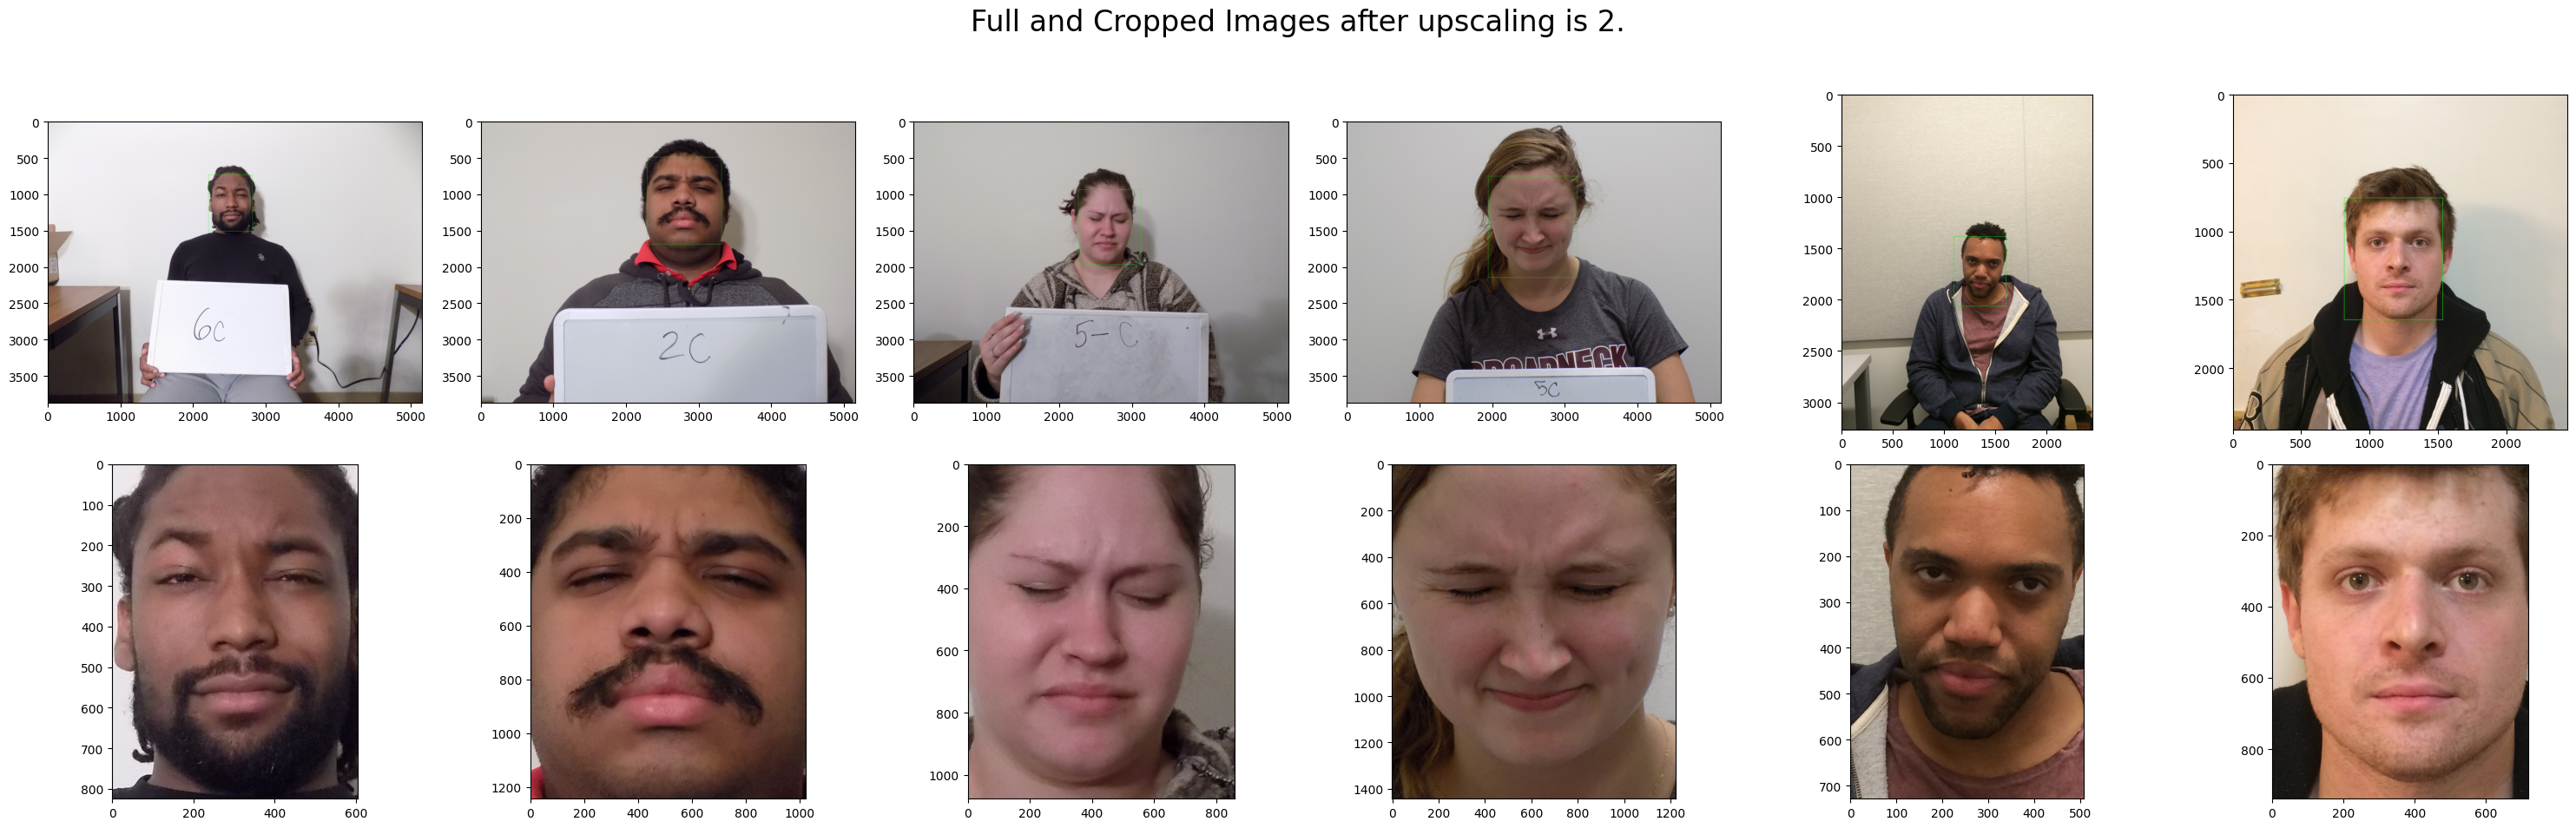

In [38]:
# Define indices for which images will be displayed
indices1 = [0, 2, 3, 5, 9, 12]
indices2 = [i for i in range(len(unidentified_upsampled_face_df)) if i != 4]

# Visualize images for the first set of indices
visualize_images(root_output, unidentified_faces_df, indices1, 'after upscaling is 2.', combined_fig_path=plot_figures+'identified_images_combined.png')

##### These images illustrate cases where face detection did not succeed despite upsampling.

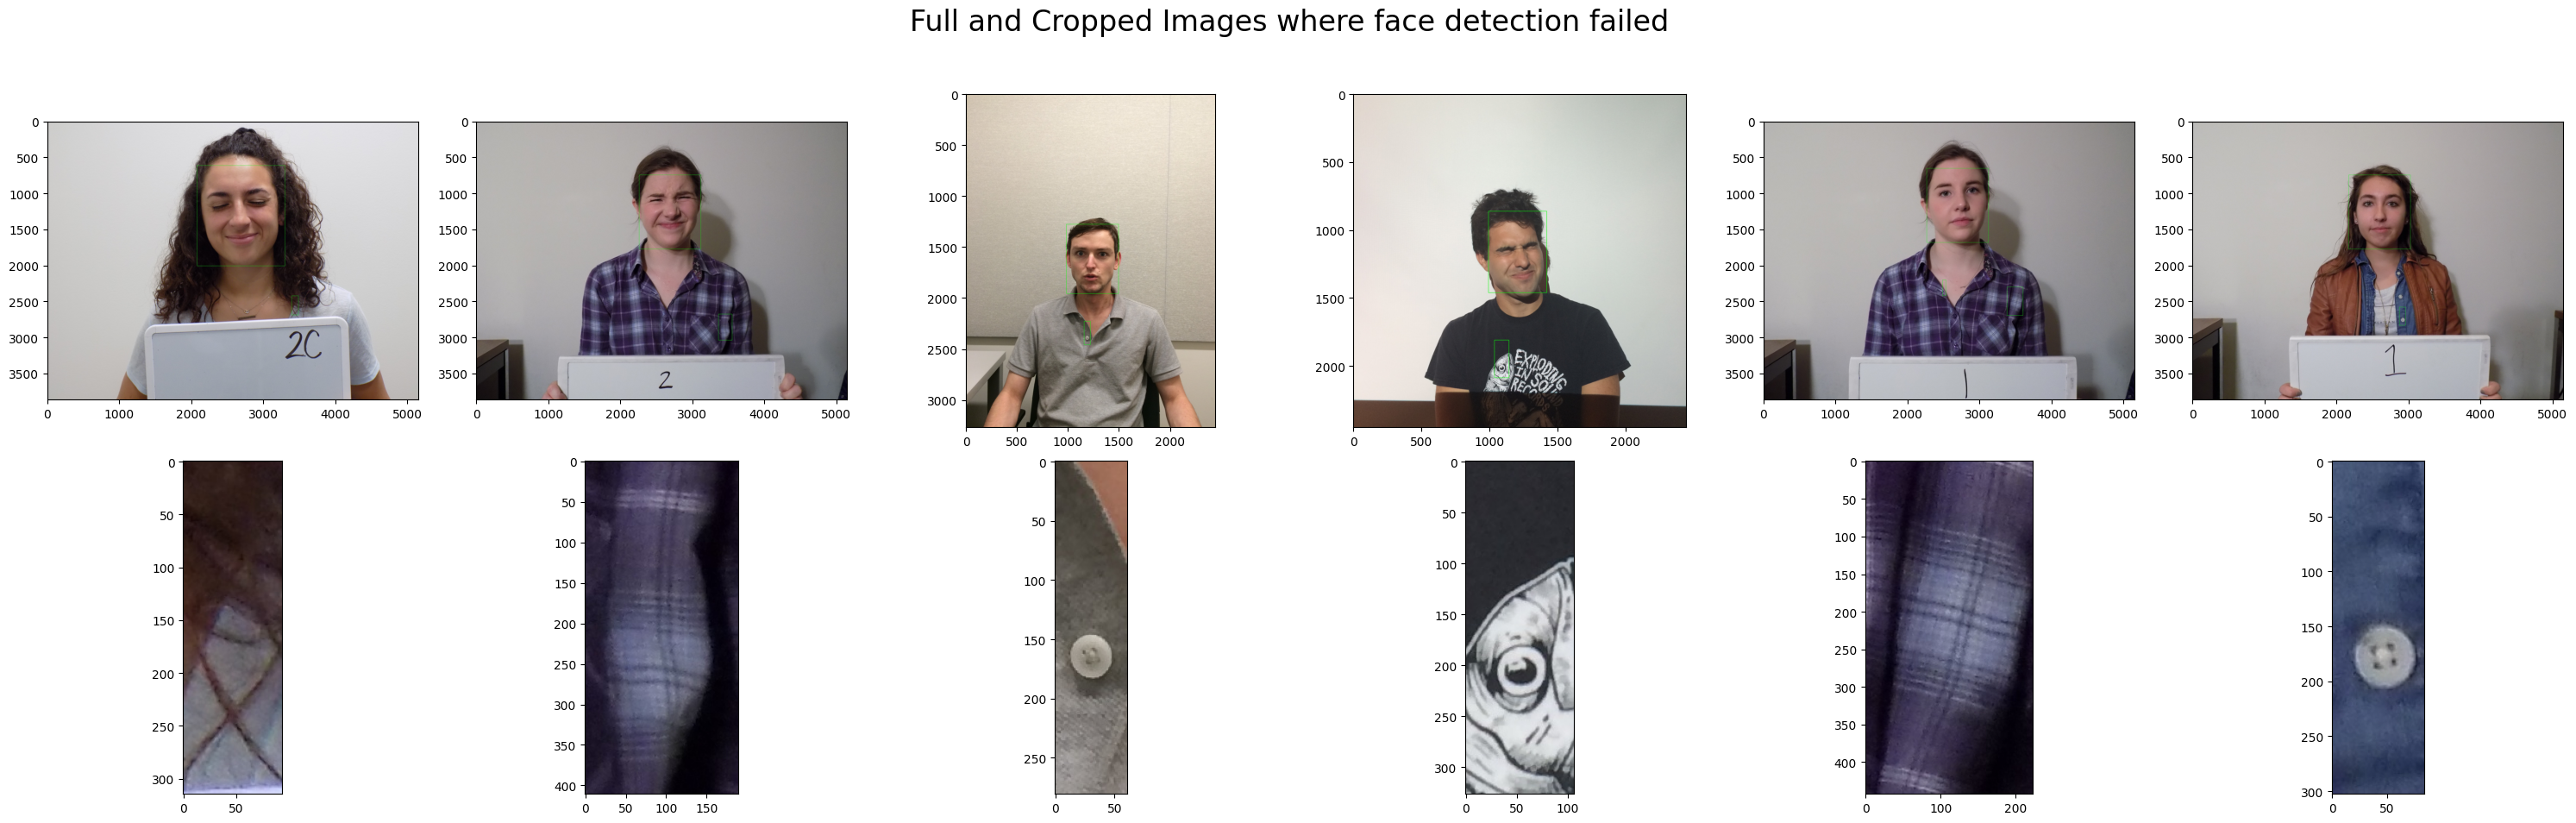

In [39]:
# Visualize images for the second set of indices
visualize_images(root_output, unidentified_upsampled_face_df, indices2, 'where face detection failed', combined_fig_path=plot_figures+'unidentified_images_combined.png')

##### The issue occurred because the model detected multiple faces in a single image and cropped the second image instead of the first one. Even after upsampling, there were 7 faces that weren't identified by the model. Let's evaluate the `OpenCV` model.

### Visual Evaluation of  `opencv` model.
##### Each image was checked manually, and some images were found with multiple faces detected and some faces were not cropped correctly. The image names that were not properly processed were noted and stored in a text file `opencv_log.txt`.

In [40]:
# Open the log file in read mode
with open(opencv_log, 'r') as file:
    # Read the file contents and split by new lines to create a list
    opencv_log_list = file.read().split('\n')

# Split each entry in the list by ' -' to separate file paths from results
opencv_log_list = [values.split(' -') for values in opencv_log_list]

# Create a DataFrame from the processed list with appropriate column names
open_cv_df = pd.DataFrame(data=opencv_log_list, columns=['Files Path', 'Results'])

# Trim whitespace from the 'Results' and 'Files Path' column
open_cv_df['Files Path'] = open_cv_df['Files Path'].str.strip()
open_cv_df['Results'] = open_cv_df['Results'].str.strip()

# Split and Store file names in File Names column
open_cv_df['File Names'] = [path.split('/')[-1].split('.')[0] for path in open_cv_df['Files Path']]

# Display the first few rows of the DataFrame
open_cv_df.head()

Files Path  \
0  P:/Dessertation/DPD Dataset/Stimuli/Expression...   
1  P:/Dessertation/DPD Dataset/Stimuli/Expression...   
2  P:/Dessertation/DPD Dataset/Stimuli/Expression...   
3  P:/Dessertation/DPD Dataset/Stimuli/Expression...   
4  P:/Dessertation/DPD Dataset/Stimuli/Expression...   

                        Results      File Names  
0              Processing done.  DPD_1_AF10_p2c  
1              Processing done.  DPD_1_AF10_p4c  
2  More than one face detected.  DPD_1_AF10_p6c  
3              Processing done.  DPD_1_AF11_p6c  
4              Processing done.  DPD_1_AF12_p3c

##### As we can see, we have `opencv` logs for all 802 images. Let's see how many faces our model identified out of these 802 images.

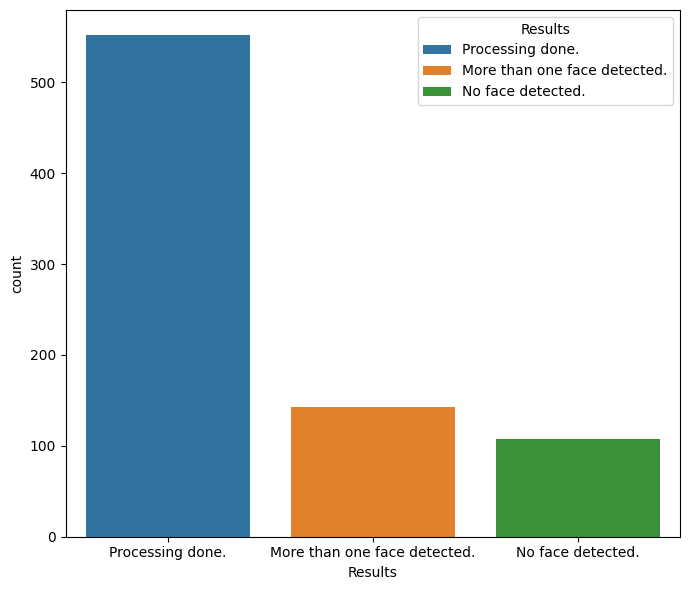

In [41]:
# Set the figure size for the plot
plt.figure(figsize=(7, 6))

# Create a count plot using seaborn
# The plot shows the count of different 'Results' in the open_cv_df DataFrame
# The 'hue' parameter is also set to 'Results' to color-code the bars by the same category
sns.countplot(data=open_cv_df, x='Results', hue='Results')

# Adjust the plot to ensure everything fits without overlapping
plt.tight_layout()

# Save figure
plt.savefig(plot_figures+'opencv_dected_distributions.png')

# Display the plot
plt.show()

##### We observed that approximately 600 images had faces detected properly, around 130 images detected more than one face in an image, and 100 faces were not identified by the model.
##### Therefore, we can proceed with the `face_recognition` model as it successfully identified a significant number of faces. For the 7 faces that were not identified by the `face_recognition` model, we will either replace them through `manual cropping` or use the faces cropped by `OpenCV` if available.

##### Let's first check if those 7 faces are identified by the `OpenCV` model.

In [42]:
# Initialize an empty array to store indentified faces from open cv model
identified_faces = []

# Iterate through each entry in 'Identified Full Faces' column of unidentified_upsampled_face_df
for faces, features in zip(unidentified_upsampled_face_df['Identified Full Faces'], features_cropped_df['Identified Full Faces']):
    # Extract the file name from the path and remove the extension
    faces_split = faces.split('/')[-1].split('.')[0]
    features_split = features.split('/')[-1].split('.')[0]
    # Check if OpenCV has successfully processed and identified the face
    if ((len(open_cv_df[(open_cv_df['File Names'] == faces_split) & (open_cv_df['Results'] == 'Processing done.')]['Files Path']) != 0) or 
            (len(open_cv_df[(open_cv_df['File Names'] == features_split) & (open_cv_df['Results'] == 'Processing done.')]['Files Path']) != 0)):
        identified_faces.append(faces_split)
        identified_faces.append(features_split)
        print('OpenCV model identified:\t\t', faces_split)
        print('OpenCV model identified (Features):\t', features_split)
    else:
        print('OpenCV couldn\'t identify:\t\t', faces_split)
        print('OpenCV couldn\'t identify (Features):\t', features_split)

OpenCV model identified:		 DPD_1_LF14_p2c
OpenCV model identified (Features):	 DPD_1_BM1alt_p5
OpenCV model identified:		 DPD_1_WF15_p2c
OpenCV model identified (Features):	 DPD_1_WM40_p4c


# Conclusion

##### We can see that out of the 7 faces which were not identified by the `face_recognition` model, 3 were identified by the `OpenCV` model. We'll replace those 3 faces with the ones identified by the `OpenCV` model, and for the remaining 4, we'll use `manually cropped` face images for further analysis. Moreover, for the 2 faces whose facial features where cropped will be replace by `manual cropped` images.

In [43]:
# Create an empty DataFrame with specified columns to store the final images
final_faces_dataframe = pd.DataFrame(columns=['Identified Full Faces', 'Cropped Faces'])

replace_from, replace_to = 'Hog_Model', 'Final_cropped_pictures'

# Iterate over each row in the DataFrame containing upsampled face data
for index, (full_face, crop_face) in enumerate(zip(unidentified_upsampled_face_df['Identified Full Faces'], unidentified_upsampled_face_df['Cropped Faces'])):
    # Replace 'Hog Model' with 'Final cropped pictures' in the full face path and store it in the new DataFrame
    final_faces_dataframe.loc[index, 'Identified Full Faces'] = full_face.replace(replace_from, replace_to)

    crop_exists = crop_face.replace(replace_from, replace_to)
    
    # Check if the cropped face image exists with the modified path
    if os.path.exists(root_output + crop_exists):
        # If the cropped face image exists, store the modified path in the new DataFrame
        final_faces_dataframe.loc[index, 'Cropped Faces'] = crop_exists
    # Check if the cropped face image exists with .PNG extension
    elif os.path.exists(root_output + crop_exists.replace('.jpg', '.PNG')):
        # If the cropped face image with .PNG extension exists, store the modified path in the new DataFrame
        final_faces_dataframe.loc[index, 'Cropped Faces'] = crop_exists.replace('.jpg', '.PNG')

# Display the first few rows of the new DataFrame to verify the results
final_faces_dataframe.head()

Identified Full Faces  \
0  /Output_results/Data_PreProcessing/Final_cropp...   
1  /Output_results/Data_PreProcessing/Final_cropp...   
2  /Output_results/Data_PreProcessing/Final_cropp...   
3  /Output_results/Data_PreProcessing/Final_cropp...   
4  /Output_results/Data_PreProcessing/Final_cropp...   

                                       Cropped Faces  
0  /Output_results/Data_PreProcessing/Final_cropp...  
1  /Output_results/Data_PreProcessing/Final_cropp...  
2  /Output_results/Data_PreProcessing/Final_cropp...  
3  /Output_results/Data_PreProcessing/Final_cropp...  
4  /Output_results/Data_PreProcessing/Final_cropp...

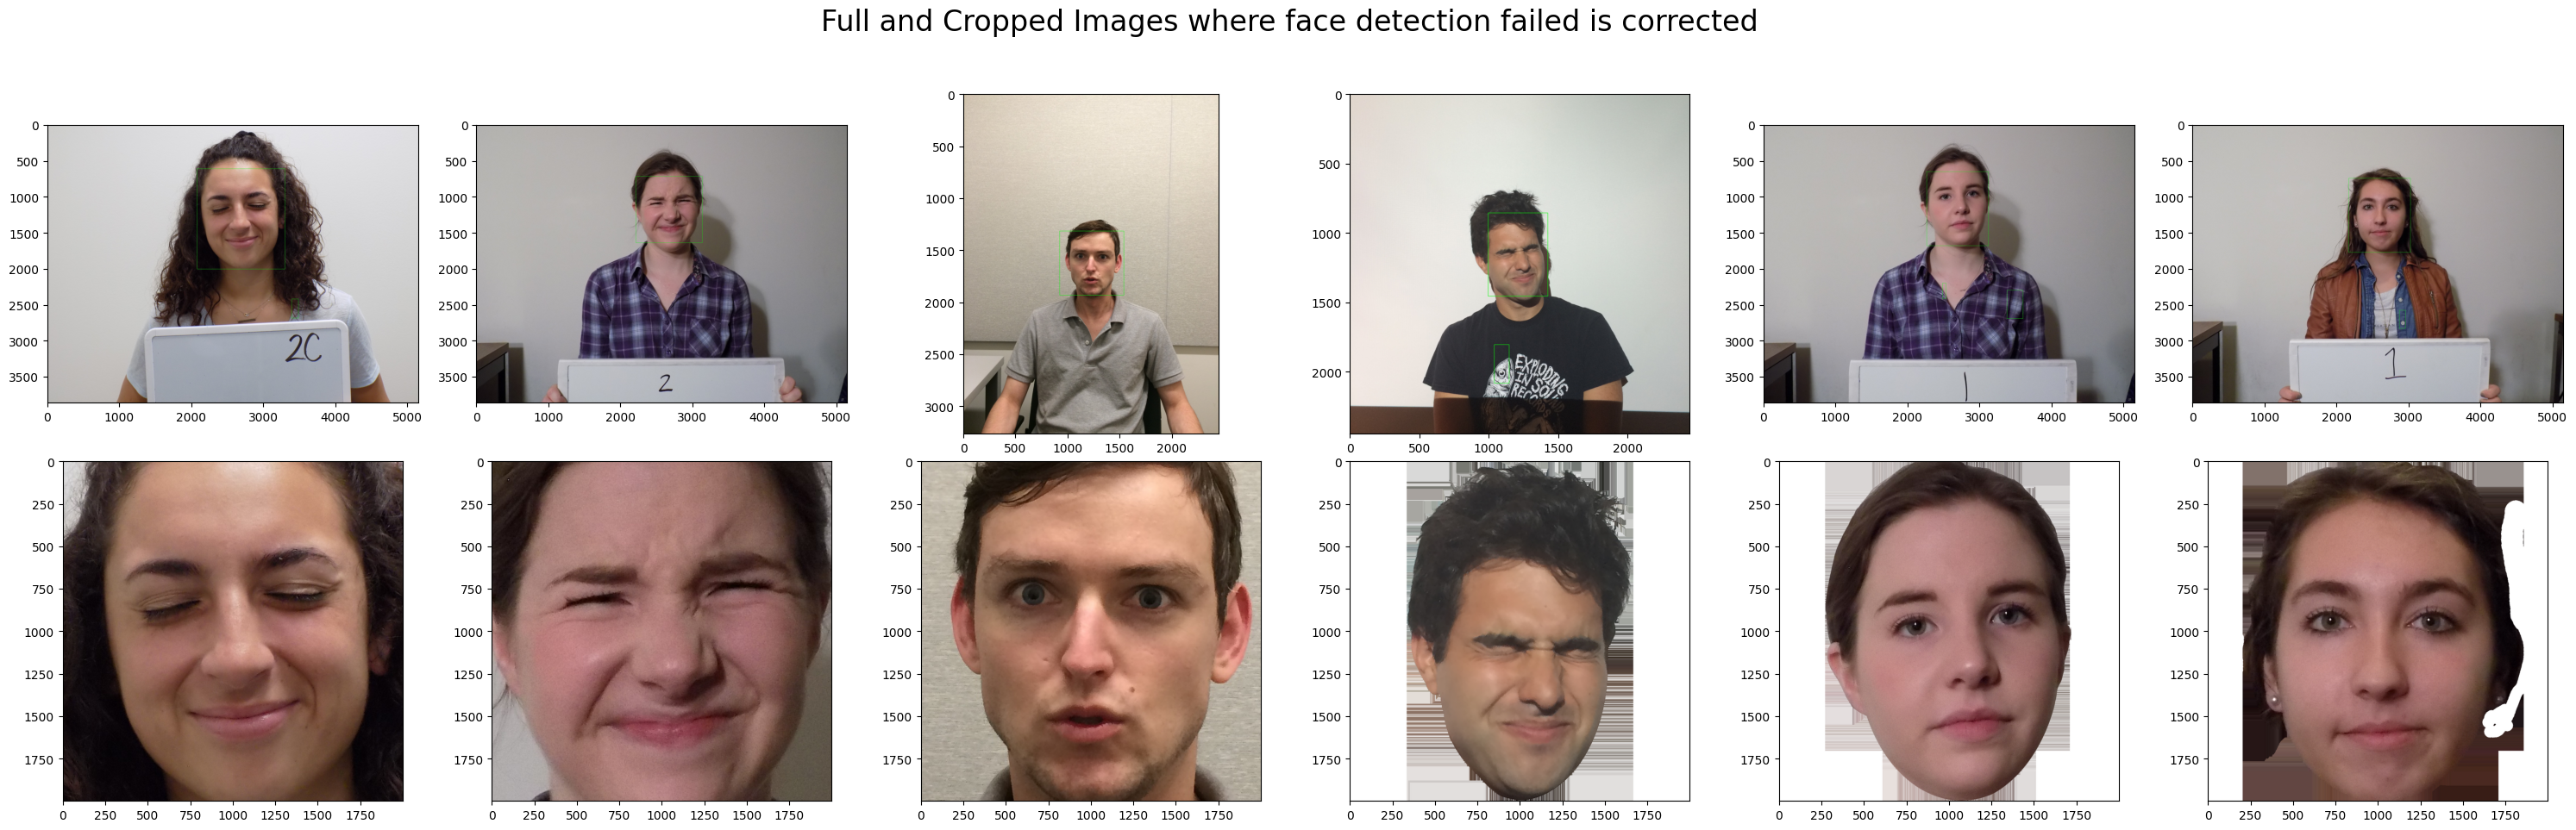

In [44]:
# Redefine indices2 for final_faces_dataframe
indices = [i for i in range(len(final_faces_dataframe)) if i!=4]

# Visualize images for the indices
visualize_images(root_output, final_faces_dataframe, indices, 'where face detection failed is corrected',  combined_fig_path=plot_figures+'final_faces_corrected.png')

##### As you can see, all the images were correctly cropped and placed in the `final_cropped_faces` path.

# Resizing Images to Uniform Dimensions

##### Resizing Pixels of the Image Files from the `final_cropped_faces`.
##### We'll visualize the dimensions and take the mean dimension of these cropped images, then resize all images to this mean dimension.

In [51]:
def find_jpg_files(directory):
    # Ensure the directory paths are absolute
    directory = os.path.abspath(directory)
    
    # Use glob to find all .jpg and .png files recursively
    jpg_files = glob(os.path.join(directory, '**', '*.jpg'), recursive=True)
    png_files = glob(os.path.join(directory, '**', '*.png'), recursive=True)
    
    # Combine lists of .jpg and .png files
    all_files = jpg_files + png_files
    
    # Filter out files that are in the excluded directory
    filtered_files = [f for f in all_files]
    
    return filtered_files

# Define the directory path and the directory to exclude
directory_path = final_cropped_faces

# Get all .jpg and .png files from the directory, excluding the specified directory
filtered_files = find_jpg_files(directory_path)

# Print the total number of found .jpg and .png files
print(f"Total jpg and png files found': {len(filtered_files)}")

Total jpg and png files found': 802


##### Since our mean pixel values for `Width` and `Height` exceed 800, we can resize cropped images to 256 x 256 `Width` and `Height`.

### Image Resizing with OpenCV
##### This script resizes images from a specified directory to 256x256 pixels using OpenCV's cv2.resize function with the cv2.INTER_AREA interpolation method, which is well-suited for downsampling. The resized images are saved to a new directory, ensuring minimal distortion and preserving important features for further analysis or model training.

In [85]:
# Create the target directory if it doesn't exist
target_directory = ("/".join(final_cropped_faces.split("/")[:-2]) + 
                    "/DPD_Data_Resized/Resized_and_Normalized_Images_200x200/")
os.makedirs(target_directory, exist_ok=True)

images_aug = (glob(os.path.join(final_cropped_faces, "**", "*.jpg"), recursive=True) + \
              glob(os.path.join(final_cropped_faces, "**", "*.png"), recursive=True))

for img_aug in images_aug:
    # Save the Augmented & Generated image using OpenCV
    save_path = ((root_output+'/'+img_aug.replace("\\","/")) \
                 .replace('Output_results/Data_PreProcessing/Final_cropped_pictures/Cropped_Faces/',
                          target_directory))
    resize_image = cv2.resize(src=(cv2.imread(img_aug)), dsize=(256,256), interpolation=cv2.INTER_AREA)
    cv2.imwrite(filename=save_path, img=resize_image)
    print("Saved:",save_path)

Saved: D:/MS/Dissertation/Output_results/Data_PreProcessing/DPD_Data_Resized/Resized_and_Normalized_Images_200x200/Expression_Images/Asian_female_participants/DPD_1_AF10_p2c.JPG
Saved: D:/MS/Dissertation/Output_results/Data_PreProcessing/DPD_Data_Resized/Resized_and_Normalized_Images_200x200/Expression_Images/Asian_female_participants/DPD_1_AF10_p4c.JPG
Saved: D:/MS/Dissertation/Output_results/Data_PreProcessing/DPD_Data_Resized/Resized_and_Normalized_Images_200x200/Expression_Images/Asian_female_participants/DPD_1_AF10_p6c.JPG
Saved: D:/MS/Dissertation/Output_results/Data_PreProcessing/DPD_Data_Resized/Resized_and_Normalized_Images_200x200/Expression_Images/Asian_female_participants/DPD_1_AF11_p6c.JPG
Saved: D:/MS/Dissertation/Output_results/Data_PreProcessing/DPD_Data_Resized/Resized_and_Normalized_Images_200x200/Expression_Images/Asian_female_participants/DPD_1_AF12_p3c.JPG
Saved: D:/MS/Dissertation/Output_results/Data_PreProcessing/DPD_Data_Resized/Resized_and_Normalized_Images_200

# Faces Cropped for SimSwap Model

##### This script provides functionality to crop edges and resize images, then process and save them from a specified input directory to an output directory. The `crop_edges` function removes a percentage of the image's edges, while the `resize_image` function resizes the image to a target size while maintaining its aspect ratio. The `process_and_save_images` function handles reading, processing, and saving of images, including creating necessary directories and handling exceptions.

In [86]:
def resize_images(image, img_dim):
    if image.shape[0] < img_dim[0] or image.shape[1] < img_dim[1]:
        return cv2.resize(src=image, dsize=img_dim, interpolation=cv2.INTER_LANCZOS4)
    elif image.shape[0] >= img_dim[0] or image.shape[1] >= img_dim[1]:
        return cv2.resize(src=image, dsize=img_dim, interpolation=cv2.INTER_AREA)
    
def crop_edges(img, crop_percentage=0.07):
    """
    Crop edges of the image by the given percentage.
    
    Args:
        img (PIL.Image.Image): The input image to be cropped.
        crop_percentage (float): The percentage of the image edges to crop. 
                                 Should be between 0 and 1.
    
    Returns:
        PIL.Image.Image: The cropped image.
    """
    width, height = img.size

    # Calculate cropping dimensions based on the percentage
    crop_w = int(width * crop_percentage)
    crop_h = int(height * crop_percentage)

    # Define the cropping box and crop the image
    cropped_img = img.crop((crop_w, crop_h, width - crop_w, height - crop_h))
    return cropped_img

def resize_image(img, target_size=(2000, 2000)):
    """
    Resize the image to the target size while maintaining aspect ratio.
    
    Args:
        img (PIL.Image.Image): The input image to be resized.
        target_size (tuple): The target size (width, height) to resize the image to.
    
    Returns:
        PIL.Image.Image: The resized image.
    """
    # Resize the image while maintaining the aspect ratio
    img.thumbnail(target_size, Image.LANCZOS)
    
    # Create a new image with the target size and paste the resized image onto it
    resized_img = Image.new("RGB", target_size, (255, 255, 255))
    img_width, img_height = img.size
    left = (target_size[0] - img_width) / 2
    top = (target_size[1] - img_height) / 2
    resized_img.paste(img, (int(left), int(top)))
    
    return resized_img

def rotate_image(img):
    """
    Rotate the image based on EXIF orientation tag.
    
    Args:
        img (PIL.Image.Image): The input image to be rotated if needed.
    
    Returns:
        PIL.Image.Image: The rotated image if needed.
    """
    try:
        # Extract EXIF data
        exif = img._getexif()
        if exif is not None:
            for tag, value in exif.items():
                if tag in ExifTags.TAGS and ExifTags.TAGS[tag] == 'Orientation':
                    # Rotate based on orientation
                    if value == 3:
                        img = img.rotate(180, expand=True)
                    elif value == 6:
                        img = img.rotate(270, expand=True)
                    elif value == 8:
                        img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # No EXIF data or unsupported orientation
        pass
    
    return img

def process_and_save_images(input_dir, output_dir, crop_percentage=0.1):
    """
    Process and save cropped and resized images from the input directory to the output directory.
    
    Args:
        input_dir (str): The path to the input directory containing the images.
        output_dir (str): The path to the output directory where processed images will be saved.
        crop_percentage (float): The percentage of the image edges to crop. 
                                 Should be between 0 and 1.
    
    Returns:
        None
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Track the number of processed images
    image_count = 0
    
    # Walk through the input directory
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, filename)
                try:
                    # Open the image file
                    img = Image.open(img_path)
                    
                    # Rotate the image based on EXIF data
                    img = rotate_image(img)
                    
                    # Crop and resize the image
                    cropped_img = crop_edges(img, crop_percentage)
                    resized_img = resize_image(cropped_img)
                    
                    # Define the output path and ensure its directory exists
                    relative_path = os.path.relpath(img_path, input_dir)
                    output_path = os.path.join(output_dir, relative_path)
                    os.makedirs(os.path.dirname(output_path), exist_ok=True)
                    
                    # Save the processed image
                    resized_img.save(output_path)
                    
                    image_count += 1
                    if image_count % 10 == 0:  # Print status every 10 images
                        print(f'Processed and saved {image_count} images...')
                
                except Exception as e:
                    # Print error message if there's an issue processing the image
                    print(f"Error processing {img_path}: {e}")

    print(f"Finished processing {image_count} images.")

##### This code snippet sets up the directories for processing and saving images. It concatenates the base path of `expression_images` with the name of the first subdirectory (excluding the base path) to form `expression_dir`. It then specifies the `output_dir` where the processed images will be saved. Finally, it calls the `process_and_save_images` function to process and save the images from the `expression_dir` to `output_dir`.

In [51]:
# Define the directory containing the expression images and the output directory
expression_images = 'D:/MS/Dissertation/Output_results/SimSwap'  # Base path for expression images
expression_dir = expression_images + os.listdir(expression_images)[1] + "/"  # Construct the full path for the expression images subdirectory
output_dir = 'D:/MS/Dissertation/Output_results/Faces_Cropped_SimSwap/Expression_Images'  # Output directory for processed images

# Process and save images
process_and_save_images(expression_dir, output_dir)

D:/MS/Dissertation/Datasets/DPD Dataset/Expression Images/Unedited/
Processed and saved 10 images...
Processed and saved 20 images...
Processed and saved 30 images...
Processed and saved 40 images...
Processed and saved 50 images...
Processed and saved 60 images...
Processed and saved 70 images...
Processed and saved 80 images...
Processed and saved 90 images...
Processed and saved 100 images...
Processed and saved 110 images...
Processed and saved 120 images...
Processed and saved 130 images...
Processed and saved 140 images...
Processed and saved 150 images...
Processed and saved 160 images...
Processed and saved 170 images...
Processed and saved 180 images...
Processed and saved 190 images...
Processed and saved 200 images...
Processed and saved 210 images...
Processed and saved 220 images...
Processed and saved 230 images...
Processed and saved 240 images...
Processed and saved 250 images...
Processed and saved 260 images...
Processed and saved 270 images...
Processed and saved 280

##### This code snippet sets up the directories for processing and saving neutral images. It constructs `neutral_dir` by concatenating the base path `neutral_images` with the name of the first subdirectory within it. The `output_dir` specifies where the processed neutral images will be saved. The `process_and_save_images` function is then called to handle the processing and saving of images from `neutral_dir` to `output_dir`.

In [53]:
# Define the directory containing the neutral images and the output directory
neutral_images = 'D:/MS/Dissertation/Datasets/DPD Dataset/Neutral Images/'  # Base path for neutral images
neutral_dir = neutral_images + os.listdir(neutral_images)[1] + "/"  # Construct the full path for the neutral images subdirectory
output_dir = 'D:/MS/Dissertation/Output_results/Faces_Cropped_SimSwap/Neutral_Images/'  # Output directory for processed images

# Process and save images
process_and_save_images(neutral_dir, output_dir)

Processed and saved 10 images...
Processed and saved 20 images...
Processed and saved 30 images...
Processed and saved 40 images...
Processed and saved 50 images...
Processed and saved 60 images...
Processed and saved 70 images...
Processed and saved 80 images...
Processed and saved 90 images...
Processed and saved 100 images...
Processed and saved 110 images...
Processed and saved 120 images...
Processed and saved 130 images...
Processed and saved 140 images...
Processed and saved 150 images...
Processed and saved 160 images...
Processed and saved 170 images...
Processed and saved 180 images...
Processed and saved 190 images...
Processed and saved 200 images...
Processed and saved 210 images...
Finished processing 219 images.


##### Let's look at 6 random images with corresponding `fully identified faces`, `cropped faces`, and `resized cropped faces`.

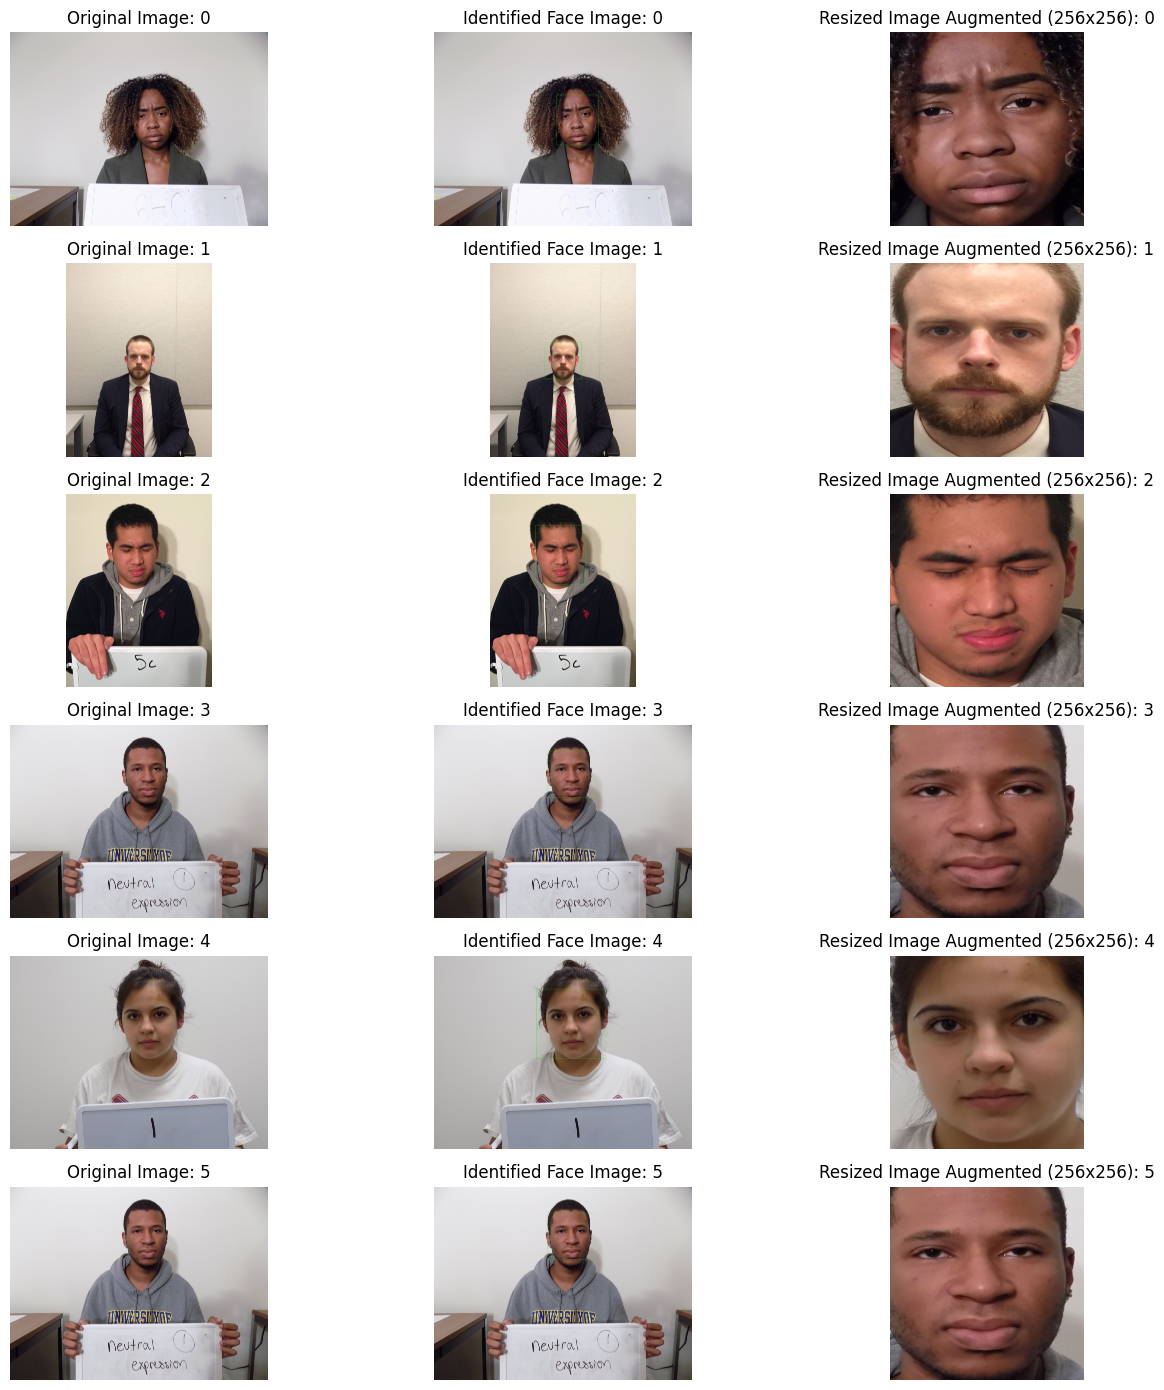

In [117]:
num_plots = 6  # Number of plots to display

# Get all image file paths (JPG and PNG) from the original image directory
original_image_data = (glob(os.path.join(root_output + '/' + dpd_root_path, "**", "*.jpg"), recursive=True) + \
                       glob(os.path.join(root_output + '/' + dpd_root_path, "**", "*.png"), recursive=True))

# Get all image file paths (JPG and PNG) from the cropped image directory
cropped_image_data = (glob(os.path.join(root_output + '/' + final_cropped_faces, "**", "*.jpg"), recursive=True) + \
                      glob(os.path.join(root_output + '/' + final_cropped_faces, "**", "*.png"), recursive=True))

# Normalize file paths to use forward slashes
cropped_image_data = list(map(lambda x: x.replace("\\", "/"), cropped_image_data))

# Extract filenames from the cropped image paths for easier lookup
cropped_filenames = set(file_path.replace("\\", "/").split("/")[-1] for file_path in cropped_image_data)

# Get all image file paths (JPG and PNG) from the identified full faces directory
full_idn_image_data = (glob(os.path.join(final_cropped_faces.replace('Cropped_Faces', 'Identified_Full_Faces'), "**", "*.jpg"), recursive=True) + \
                       glob(os.path.join(final_cropped_faces.replace('Cropped_Faces', 'Identified_Full_Faces'), "**", "*.png"), recursive=True))

# Filter original image paths to include only those containing "Unedited" and whose filenames are in cropped_filenames
original_image_data = [file_path.replace("\\", "/") for file_path in original_image_data 
                       if "Unedited" in file_path.replace("\\", "/").split("/") and 
                       file_path.replace("\\", "/").split("/")[-1] in cropped_filenames]

full_idn_image_data = [file_path.replace("\\", "/") for file_path in full_idn_image_data 
                       if file_path.replace("\\", "/").split("/")[-1] in cropped_filenames]

# Generate random indices to select images from the filtered list
random_indices = np.random.randint(0, len(original_image_data), size=(num_plots,))

# Create a figure with a grid of subplots
fig, axes = plt.subplots(num_plots, 3, figsize=(14, 14))

# Iterate over each subplot
for plot_index, index in enumerate(random_indices):
    # Load images based on the random index
    original_img = cv2.imread(original_image_data[index])
    cropped_img = cv2.imread(full_idn_image_data[index])
    resized_img_batch_aug = cv2.imread(cropped_image_data[index])

    # Plot the original image
    axes[plot_index, 0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[plot_index, 0].set_title(f"Original Image: {plot_index}")
    axes[plot_index, 0].axis("off")

    # Plot the cropped image
    axes[plot_index, 1].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    axes[plot_index, 1].set_title(f"Identified Face Image: {plot_index}")
    axes[plot_index, 1].axis("off")

    # Plot the resized and augmented image
    axes[plot_index, 2].imshow(cv2.cvtColor(resized_img_batch_aug, cv2.COLOR_BGR2RGB))
    axes[plot_index, 2].set_title(f"Resized Image Augmented (256x256): {plot_index}")
    axes[plot_index, 2].axis("off")

# Adjust layout for better display
plt.tight_layout()

# Save the figure
plt.savefig(plot_figures + 'final_output.png')

# Show the plot
plt.show()